# Parameterising Small Molecules with OpenFF

TODO: Add outline with clickable sections and clear workflow, clearly acknowledge where/ who material was taken from (mainly previous workshop), add jupyter cheat sheet...

## The plan:

| Action | Software|
|--|--|
| Load and inspect a force field | OpenFF Toolkit
| Create a representation of your chemical system | OpenFF Toolkit
| Parameterise your system and run a quick simulation | OpenFF Interchange, OpenMM
| Rapidly assign partial charges with a graph neural network model | OpenFF Toolkit, OpenFF NAGL Models



## 1. Force fields are specified in `.offxml` files and can be loaded with the `ForceField` class

OpenFF's force fields use the The SMIRks Native Open Force Field (SMIRNOFF) [specification](https://openforcefield.github.io/standards/standards/smirnoff/) and are conventionally encoded in `.offxml` files. The spec fully describes the contents of a SMIRNOFF force field, how parameters should be applied, and several other important usage details. You could implement a SMIRNOFF engine in your own code, but conveniently the OpenFF Toolkit already provides this and a handful of utilities. Let's load up the latest OpenFF small molecule force field, OpenFF 2.2.1, and inspect its contents! This force field shares the code name "Sage" with all other force fields with the same major version number (2.x.x).

In [1]:
from openff.toolkit import ForceField

sage = ForceField("openff-2.2.1.offxml")
sage

/home/campus.ncl.ac.uk/nfc78/miniforge3/envs/openff-env/lib/python3.12/site-packages/smirnoff99frosst/smirnoff99frosst.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


If you'd like to see the raw file on disk that's being parsed, [here's the file on GitHub](https://github.com/openforcefield/openff-forcefields/blob/main/openforcefields/offxml/openff-2.2.1.offxml).

Each section of a force field is stored in memory within `ParameterHandler` objects, which can be looked up with brackets (just like looking up values in a dictionary):

In [5]:
print(sage.registered_parameter_handlers)

vdw_handler = sage["vdW"]
vdw_handler

['Constraints', 'Bonds', 'Angles', 'ProperTorsions', 'ImproperTorsions', 'vdW', 'Electrostatics', 'LibraryCharges', 'ToolkitAM1BCC']


Each `ParameterHandler` in turn stores a list of parameters in its `.parameters` attribute, in addition to some information specific to its portion of the potential energy function:

In [6]:
(vdw_handler.cutoff, vdw_handler.combining_rules, vdw_handler.scale14)

vdw_handler.parameters

[<vdWType with smirks: [#1:1]  epsilon: 0.0157 kilocalorie / mole  id: n1  rmin_half: 0.6 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X4]  epsilon: 0.01577948280971 kilocalorie / mole  id: n2  rmin_half: 1.48419980825 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X4]-[#7,#8,#9,#16,#17,#35]  epsilon: 0.01640924602775 kilocalorie / mole  id: n3  rmin_half: 1.449786411317 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]  epsilon: 0.0157 kilocalorie / mole  id: n4  rmin_half: 1.287 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]  epsilon: 0.0157 kilocalorie / mole  id: n5  rmin_half: 1.187 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X4]~[*+1,*+2]  epsilon: 0.0157 kilocalorie / mole  id: n6  rmin_half: 1.1 angstrom  >,
 <vdWType with smirks: [#1:1]-[#6X3]  epsilon: 0.01561134320353 kilocalorie / mole  id: n7  rmin_half: 1.443812569645 angstrom  >,
 <vdWType with sm

From here you can inspect all the way down to individual parameters, which are stored in custom objects (in this case, `vdWType`). Let's look at the type with id `n16`, which looks like a generic carbon with four bonded neighbors:

In [8]:
vdw_type = vdw_handler.parameters[15]
vdw_type

<vdWType with smirks: [#6X4:1]  epsilon: 0.1088406109251 kilocalorie / mole  id: n16  rmin_half: 1.896698071741 angstrom  >

Note that the type contains both the physical parameters (sigma and epsilon, for a conventional 12-6 Lennard-Jones potential), but also an associated SMIRKS pattern. This particular SMIRKS pattern is fairly simple, but some can get much more complex.

The toolkit uses these SMIRKS patterns and direct chemical perception to assign parameters to particular atoms (or bonds, angles, etc.).

We'll use OpenFF 2.2.1 for the remainder of this tutorial, but you can learn more about this and other SMIRNOFF force fields below:
<details>
  <summary><b>Click here to learn about available and planned SMIRNOFF force fields</b></summary>

# Existing force fields

## From OpenFF

### smirnoff99Frosst

This [force field](https://github.com/openforcefield/smirnoff99Frosst) is mostly a historical artifact today. It is the first SMIRNOFF force field, dating back to 2016. It is based on Merck-Frosst's [parm@frosst](http://www.ccl.net/cca/data/parm_at_Frosst/) and an old AMBER force field, parm99, which predates GAFF.

It is not recommended for general use today, but you might see it in papers that compare the performance of different force fields.

### Parsley

The Parsley line of force fields (`openff-1.y.z.offxml`) was OpenFF's [first full force field release](https://openforcefield.org/community/news/general/introducing-openforcefield-1.0/). Based on `smirnoff99Frosst`, these force fields are primarily re-fits of valence parameters using a large number of QM structures pulled from QCArchive. The first version was 1.0.0 and subsequent re-fits produced versions 1.1.0, 1.2.0, and 1.3.0. More detail is provided in an [associated paper](https://pubs.acs.org/doi/10.1021/acs.jctc.1c00571).

### Sage

The Sage line of force fields (`openff-2.y.z.offxml`) continued the process of fitting to more (and more diverse) QM datasets, but also included a re-fit of the Lennard-Jones parameters. Small molecule geometries and energies [improved, in general,](https://openforcefield.org/community/news/general/sage2.0.0-release/) significantly over Parsley. These improvements notably transferred to protein-ligand binding free energies despite Sage not being specifically fit to them. For more, see the [associated paper](https://pubs.acs.org/doi/10.1021/acs.jctc.3c00039).

[Subsequent releases](https://github.com/openforcefield/openff-forcefields/releases) used different fitting procedures and tweaks to parameter typing to improve performance and address issues with several specific chemistries. The latest release, **Sage 2.2.1 (`openff-2.2.1.offxml`) is the recommended force field for small molecule studies.**

## Ports

### Water models

OpenFF has ported [several existing water models](https://github.com/openforcefield/openff-forcefields/blob/main/docs/water-models.md) to SMIRNOFF format, including:

- TIP3P
- TIP3P-FB
- TIP4P-FB
- OPC
- OPC3

Existing main-line OpenFF force fields are fit against TIP3P water, so use of others is not (currently) recommended. This might change in the future, or OpenFF might even fit a new water model in a future release.

## ff14SB

OpenFF, in collaboration with Dave Cerutti of the Amber community, created a port of [ff14SB](https://pubs.acs.org/doi/10.1021/acs.jctc.5b00255), a popular Amber protein force field. There are some small numberical differences with how improper torsions are evaluated, but all other terms reproduce a canonical Amber source to high accuracy. **This is the only protein force field currently in SMIRONOFF (`.offxml`) format** and therefore the current recommendation for use with proteins. Primarily for technical reasons, porting other Amber force fields is not planned.

## Non-main-line force fields

### SMIRNOFF plugins

https://github.com/openforcefield/smirnoff-plugins

https://github.com/jthorton/de-forcefields

# Future force fields

## From OpenFF

### Rosemary
A future line of force fields from OpenFF (code name "Rosemary", starting with `openff-3.0.0.offxml`) is intended to handle small molecules and biopolymers in a _self-consistent_ manner. The first release is expected to handle proteins, but future versions  may cover nucleic acids. The performance, depending on the metrics used, is hoped to be comparable with existing Amber-family protein force fields.

There is no specific release date planned for Rosemary, but it may be available in 2026 (a beta release candidate may also be publically available prior to the full release).

### Graph net charge assignment

TODO: UPDAATE AND MENTION 2.3

Another release, possibly in the Rosemary line, is intended to include graph-convolutional neutral network (GCNN)-based charge assignment using [NAGL](https://github.com/openforcefield/openff-nagl). Details are still being worked out, but it is expected to approximately reproduce AM1-BCC (or some variant) without the typical $O(N^3)$ scaling, making it suitable for large (>> 100 atoms) molecules).

### Virtual sites

Another release from OpenFF may include some virtual site parameters with off-center charges. No release date is planned, but the most of the supporting infrastructure is currently in place and some early studies have shown promise for better representing electrostatics of chemistries such as halogens and aromatic nitrogens.


## From you!

Anybody can write a SMIRNOFF force field! This workshop doesn't have time to cover force field _fitting_, but there are plenty of freely-available tools used today that can re-fit existing force fields or generate something new from the ground up. Once you've fit a new force field, a small Python package can distribute it in a way that the toolkit can [automatically load](https://docs.openforcefield.org/projects/toolkit/en/stable/faq.html#how-can-i-distribute-my-own-force-fields-in-smirnoff-format)!
</details>

## 2. The `Topology` class represents a chemical system containing one or more `Molecule`s

Now we've loaded our desired force field (OpenFF 2.2.1), we need to specify the chemical system we want to assign force field parameters to ("parameterise"). Our system will be represented by a `Topology`, which we will build from one or more `Molecule`s. 

As a simple example, let's build a `Topology` containing a methanol molecule:

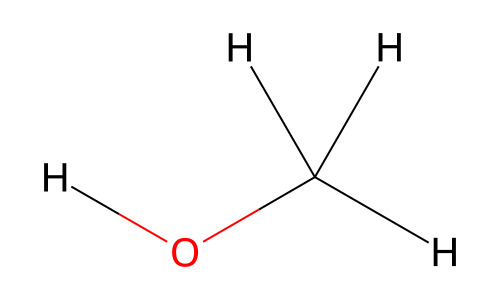

In [ ]:
from openff.toolkit import Molecule, Topology

molecule = Molecule.from_smiles("CO")
molecule

We can also visualise our molecule in 3D using NGLView, but only after generating 3D coordinates with `generate_conformers`:

In [44]:
molecule.generate_conformers(n_conformers=1)
molecule.visualize(backend="nglview")

NGLWidget()

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ⚠️ Be careful when creating molecules from SMILES with undefined stereochemistry. By default, an `UndefinedStereochemistryError` will be raised, but this can be downgraded to a warning by setting the <code>allow_undefined_stereo=True</code>. This will create a molecule with undefined stereochemistry, which might lead to incorrect parameterisation or surprising conformer generation. See the <a href="https://docs.openforcefield.org/en/latest/faq.html">"I'm getting stereochemistry errors when loading a molecule from a SMILES string" FAQ</a> for more details.
</div>

Topologies can always be assembled by constructing individual molecules and adding them together; these methods are for making common operations easier.

To convert a single `Molecule` to a `Topology`, you can use either `Molecule.to_topology()` or `Topology.from_molecules`

In [ ]:
topology = molecule.to_topology()

# Or, equivalently:
topology = Topology.from_molecules(molecules=[molecule])

From here we can add as many other molecules as we wish. For example, we can create a water molecule and it to a topology 100 times.

In [117]:
water = Molecule.from_smiles("O")
topology_with_water = Topology(topology)

for index in range(100):
    topology_with_water.add_molecule(water)

topology_with_water.n_molecules

101

<div class="alert alert-info" style="max-width: 500px; margin-left: auto; margin-right: auto;">
    ℹ️ Positions are <i>optional</i> in <code>Molecule</code> (any by extension <code>Topology</code>) objects, so visualizing this topology in 3D doesn't make sense. Using it in a simulation would requiring assigning positions using a tool like Packmol or PDBFixer. Running simulations will be discussed this afternoon.
</div>

Keeping in mind that topologies are just collections of molecules, we can look up individual molecules by index in the `Topology.molecule()` function.

In [38]:
topology.molecule(0), topology.molecule(1), topology.molecule(-1)

(Molecule with name '' and SMILES '[H][O][C]([H])([H])[H]',
 Molecule with name '' and SMILES '[H][O][H]',
 Molecule with name '' and SMILES '[H][O][H]')

<div class="alert alert-success" style="max-width: 500px; margin-left: auto; margin-right: auto; border-left: 6px solid #5cb85c; background-color: #f1fff1;">
    ✏️ <b>Exercise:</b> Build a <code>Topology</code> containing an MCL-1 ligand. Create the <code>Molecule</code> from an SDF file  (take a look at the docstring of <code>Molecule</code> to see how this can be done). Also, see <a href="https://docs.openforcefield.org/projects/toolkit/en/stable/users/molecule_cookbook.html">Molecule cookbook</a> for all the ways to make a <code>Molecule</code>. TODO: Provide SDF?
</div>


In [48]:
# Inspect the Molecule docstring
Molecule?

Init signature: Molecule(*args, **kwargs)
Docstring:     
Mutable chemical representation of a molecule, such as a small molecule or biopolymer.

.. todo :: What other API calls would be useful for supporting biopolymers as small molecules? Perhaps iterating
    over chains and residues?

Examples
--------

Create a molecule from an sdf file

>>> from openff.toolkit.utils import get_data_file_path
>>> sdf_filepath = get_data_file_path('molecules/ethanol.sdf')
>>> molecule = Molecule(sdf_filepath)

Convert to OpenEye OEMol object

>>> oemol = molecule.to_openeye()

Create a molecule from an OpenEye molecule

>>> molecule = Molecule.from_openeye(oemol)

Convert to RDKit Mol object

>>> rdmol = molecule.to_rdkit()

Create a molecule from an RDKit molecule

>>> molecule = Molecule.from_rdkit(rdmol)

Create a molecule from IUPAC name (requires the OpenEye toolkit)

>>> molecule = Molecule.from_iupac('imatinib')

Create a molecule from SMILES

>>> molecule = Molecule.from_smiles('Cc1ccccc1')

In [ ]:
# Build your topology here...

We will cover creating a topology for a protein-ligand complex this afternoon.

## 3. `Interchange` objects contain fully parameterised systems with all the information needed to start a simulation

Now we're specified our force field and our chemical system using classes from the OpenFF Tools package (`ForceField`, `Molecule`, and `Topology`), and we want to apply our force field to our chemical topologies (parameterisation).

To do this, we'll use the `Interchange` class from the OpenFF Interchange package, which stores a fully-parameterised molecular system and provides methods to write out simulation-ready input files for a number of software packages. They key objective of Interchange is to provide an intermediate inspectable state after parameterisation and before conversion to an engine-specific format. For most users, an `Interchange` forms the bridge between the OpenFF ecosystem and their simulation software of choice. The current focus is applying SMIRNOFF force fields to chemical topologies and exporting the result to engines preferred by our users. In order of stability, OpenMM, GROMACS, Amber, and LAMMPS are supported. Future development may include support for CHARMM and other engines.

Below is a summary of how data flows through a workflow utilizing OpenFF tools, including where Interchange sits in the flow.

TODO: Fix this image (tookit cut off etc)

<img src="../images/interchange_flowchart.jpg" alt="Description of image" style="max-width: 1000px; display: block; margin-left: auto; margin-right: auto;" />

An `Interchange` is most commonly constructed via the `Interchange.from_smirnoff()` class method. This method takes a SMIRNOFF force field and applies it to a molecular topology. 



In [59]:
from openff.interchange import Interchange

Interchange.from_smirnoff?

Signature:
Interchange.from_smirnoff(
    force_field: 'ForceField',
    topology: openff.toolkit.topology.topology.Topology | list[openff.toolkit.topology.molecule.Molecule],
    box=None,
    positions=None,
    charge_from_molecules: list[openff.toolkit.topology.molecule.Molecule] | None = None,
    partial_bond_orders_from_molecules: list[openff.toolkit.topology.molecule.Molecule] | None = None,
    allow_nonintegral_charges: bool = False,
) -> 'Interchange'
Docstring:
Create a new object by parameterizing a topology with a SMIRNOFF force field.

Parameters
----------
force_field : `openff.toolkit.ForceField`
    The force field to parameterize the topology with.
topology : `openff.toolkit.Topology` or `list[openff.toolkit.Molecule]`
    The topology to parameterize, or a list of molecules to construct a
    topology from and parameterize.
box : `openff.units.Quantity`, optional
    The box vectors associated with the ``Interchange``. If ``None``,
    box vectors are taken from the

In [119]:
interchange = Interchange.from_smirnoff(
    force_field=sage,
    topology=topology,
)
interchange

Interchange with 7 collections, non-periodic topology with 6 atoms.

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ℹ️ <code>ForceField.create_interchange(topology)</code> and <code>Interchange.from_smirnoff(force_field, topology)</code> do the same thing - one just wraps the other. You can use whichever, and interpret them as substitutes of one another.
</div>

An `Interchange` object stores all information known about a system; this includes its chemistry, how that chemistry is represented by a force field, and how the system is organized in 3D space. It has five components:

1. **Topology**: Stores chemical information, such as connectivity and formal charges, independently of force field
1. **Collections**: Maps the chemical information to force field parameters. The force field itself is not directly stored
1. **Positions** (optional): Cartesian co-ordinates of atoms
1. **Box vectors** (optional): Periodicity information
1. **Velocities** (optional): Cartesian velocities of atoms

Let's inspect each of these.

The `Interchange.topology` attribute carries an object of the same type provided by the toolkit and therefore provides the same API. (In the future this may change).

In [120]:
(
    interchange.topology.n_atoms,
    interchange.topology.n_bonds,
    interchange.topology.molecule(0).to_smiles(),
)

(6, 5, '[H][O][C]([H])([H])[H]')

The `Interchange.collections` attribute carries a dictionary mapping handler names to `SMIRNOFFCollection` objects. These carry the physical parameters derived from applying the force field to the topology.

In [121]:
[(key, value) for key, value in interchange.collections.items()]

[('Bonds',
  Handler 'Bonds' with expression 'k/2*(r-length)**2', 5 mapping keys, and 3 potentials),
 ('Constraints',
  Handler 'Constraints' with expression '', 4 mapping keys, and 2 potentials),
 ('Angles',
  Handler 'Angles' with expression 'k/2*(theta-angle)**2', 7 mapping keys, and 3 potentials),
 ('ProperTorsions',
  Handler 'ProperTorsions' with expression 'k*(1+cos(periodicity*theta-phase))', 3 mapping keys, and 1 potentials),
 ('ImproperTorsions',
  Handler 'ImproperTorsions' with expression 'k*(1+cos(periodicity*theta-phase))', 0 mapping keys, and 0 potentials),
 ('vdW',
  Handler 'vdW' with expression '4*epsilon*((sigma/r)**12-(sigma/r)**6)', 6 mapping keys, and 4 potentials),
 ('Electrostatics',
  Handler 'Electrostatics' with expression 'coul', 6 mapping keys, and 6 potentials)]

Note that each `SMIRNOFFCollection` specifies an algebraic expression which is used to compute the potential energy.

Let's quickly visualize this molecule with atom indices -- this is helpful for looking up particular parameters.

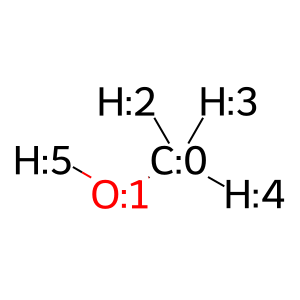

In [122]:
from rdkit.Chem import Draw
from openff.toolkit.topology import Molecule
from IPython.display import SVG


def mol_with_atom_index(molecule: Molecule, width: int = 300, height: int = 300) -> str:
    molecule_copy = Molecule(molecule)
    molecule_copy._conformers = None

    rdmol = molecule_copy.to_rdkit()

    # Build labels like "C:0", "O:1", "H:2", ...
    atom_labels = {
        atom.GetIdx(): f"{atom.GetSymbol()}:{atom.GetIdx()}"
        for atom in rdmol.GetAtoms()
    }

    drawer = Draw.MolDraw2DSVG(width, height)
    opts = drawer.drawOptions()
    for idx, label in atom_labels.items():
        opts.atomLabels[idx] = label

    Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer, rdmol)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()


SVG(mol_with_atom_index(molecule))

The `key_map` attribute of a `SMIRNOFFCollection` maps a `TopologyKey` (such as a `BondKey`) to a `PotentialKey`, which identifies unique parameters:

In [170]:
collection = interchange.collections["Bonds"]
collection.key_map

{BondKey with atom indices (0, 1): PotentialKey associated with handler 'Bonds' with id '[#6:1]-[#8:2]',
 BondKey with atom indices (0, 2): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#1:2]',
 BondKey with atom indices (0, 3): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#1:2]',
 BondKey with atom indices (0, 4): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#1:2]',
 BondKey with atom indices (1, 5): PotentialKey associated with handler 'Bonds' with id '[#8:1]-[#1:2]'}

We can see that the C-O bond (indices (0,1)) is associated with a potential key with the SMIRKS pattern `[#6:1]-[#8:2]` (specifying any carbon single-bonded to an oxygen).

To see the actual parmeters specified for this bond, we can look up the `Potential` objects using the `PotentialKey`s.

In [171]:
for topology_key, potential_key in collection.key_map.items():
    potential = collection.potentials[potential_key]
    print(f"{topology_key} -> {potential}")

atom_indices=(0, 1) bond_order=None -> parameters={'k': <Quantity(517.86177, 'kilocalorie_per_mole / angstrom ** 2')>, 'length': <Quantity(1.42626649, 'angstrom')>} map_key=None
atom_indices=(0, 2) bond_order=None -> parameters={'k': <Quantity(715.716502, 'kilocalorie_per_mole / angstrom ** 2')>, 'length': <Quantity(1.09397889, 'angstrom')>} map_key=None
atom_indices=(0, 3) bond_order=None -> parameters={'k': <Quantity(715.716502, 'kilocalorie_per_mole / angstrom ** 2')>, 'length': <Quantity(1.09397889, 'angstrom')>} map_key=None
atom_indices=(0, 4) bond_order=None -> parameters={'k': <Quantity(715.716502, 'kilocalorie_per_mole / angstrom ** 2')>, 'length': <Quantity(1.09397889, 'angstrom')>} map_key=None
atom_indices=(1, 5) bond_order=None -> parameters={'k': <Quantity(1076.78291, 'kilocalorie_per_mole / angstrom ** 2')>, 'length': <Quantity(0.975374805, 'angstrom')>} map_key=None


So our C-O bond (indices (0,1)) has a force constant of 518 kcal mol<sup>-1</sup> Å<sup>-2</sup> and an equilibrium bond length of 1.43 Å. Note that the [`ForceField.label_molecules`](https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.typing.engines.smirnoff.ForceField.html#openff.toolkit.typing.engines.smirnoff.ForceField.label_molecules) method is also useful for checking which parameters will be applied to your molecule.

<div class="alert alert-success" style="max-width: 500px; margin-left: auto; margin-right: auto; border-left: 6px solid #5cb85c; background-color: #f1fff1;">
    ✏️ <b>Exercise:</b> How many proper torsions do you expect to find in methanol? Check your answer by inspecting the <code>Interchange</code> object.
</div>

In [ ]:
# Inspect the proper torsions applied in the Interchange object...


Finally, `interchange.box` and `interchange.velocities` are `None`, although `interchange.positions` is populated because we passed a topology with a molecule that had a defined conformer, so `from_smirnoff` set atomic positions from this information:

In [178]:
interchange.positions, interchange.box, interchange.velocities

(<Quantity([[-0.03510003 -0.00050979 -0.0018054 ]
  [ 0.09661929 -0.03669733 -0.02597133]
  [-0.05984567  0.00616493  0.10523734]
  [-0.09828633 -0.08131057 -0.0462329 ]
  [-0.06630706  0.09288997 -0.05017582]
  [ 0.1629198   0.01946279  0.01894811]], 'nanometer')>,
 None,
 None)

We can create an OpenMM `Simulation` object from the `Interchange`. Note that since the `Interchange` only contains methanol and has no box vectors, this corresponds to a vacuum simulation. This probably isn't what you want, but let's run it for fun anyway -- we'll discuss running a solvated complex this afternoon.

In [199]:
import openmm
import openmm.unit
from openff.interchange import Interchange
import mdtraj
import nglview


def run_openmm(
    interchange: Interchange,
    reporter_frequency: int = 1000,
    trajectory_name: str = "preview.dcd",
):
    simulation = interchange.to_openmm_simulation(
        integrator=openmm.LangevinIntegrator(
            300 * openmm.unit.kelvin,
            1 / openmm.unit.picosecond,
            0.002 * openmm.unit.picoseconds,
        ),
    )

    dcd_reporter = openmm.app.DCDReporter(trajectory_name, reporter_frequency)
    simulation.reporters.append(dcd_reporter)

    simulation.context.setVelocitiesToTemperature(300 * openmm.unit.kelvin)
    simulation.runForClockTime(5 * openmm.unit.second)


def visualise_traj(
    topology: Topology, filename: str = "preview.dcd"
) -> nglview.NGLWidget:
    """Visualise a trajectory using nglview."""
    traj = mdtraj.load(
        filename,
        top=mdtraj.Topology.from_openmm(topology.to_openmm()),
    )

    # Superpose trajectory to the first frame
    traj.superpose(traj, 0)

    view = nglview.show_mdtraj(traj)

    return view


run_openmm(interchange)
visualise_traj(interchange.topology)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


NGLWidget(max_frame=187)

<div class="alert alert-success" style="max-width: 500px; margin-left: auto; margin-right: auto; border-left: 6px solid #5cb85c; background-color: #f1fff1;">
    ✏️ <b>Exercise:</b> Create an Interchange object for an MCL-1 ligand. Inspect the parameters assigned and run short simulation of the molecule in vacuum.
</div>

## 4. Graph Neural Networks Allow Fast Assignment of Partial Charges

You might notice that [Sage](https://github.com/openforcefield/openff-forcefields/blob/main/openforcefields/offxml/openff-2.2.1.offxml) doesn't contain tabulated charges for most atomic environments in the way it does for all other terms in the force field. Instead, it specifies:
```
<ToolkitAM1BCC version="0.3"></ToolkitAM1BCC>
```
which means that partial charges will be calculated using the common AM1-BCC method. Charges from a semi-empirical quantum chemistry calculation (Austin Model 1) are corrected (bond charge correction) to approximate charges obtained by fitting to the electrostatic potential at the HF/6-31G* level (see [Jakalian et al.](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1096-987X(20000130)21:2%3C132::AID-JCC5%3E3.0.CO;2-P)). Unfortunately, AM1-BCC scales 𝒪(N<sup>2</sup>) in the number of atoms N, making it prohibitively slow for large molecules and biopolymers.

Methods which assign partial charges using graph neural networks offer rapid assignment with better scaling. They also offer the possibility of going beyond traditionally affordable QM levels of theory by training to quickly reproduce charges from expensive calculations. For example, [EspalomaCharge](https://pubs.acs.org/doi/full/10.1021/acs.jpca.4c01287) is fit to AM1-BCC charges and offers 𝒪(N<sup>2</sup>) scaling, while [Adams et al.](https://chemrxiv.org/engage/chemrxiv/article-details/6839c94c3ba0887c33d2cd8e) trained models to reproduce atoms-in-molecules charges and electrostatic potentials obtained at a high level of theory. Here, we'll use OpenFF's [AshGC](https://zenodo.org/records/15770227/files/AshGC_methods_2025-06-30.pdf?download=1) model, which is trained to reproduce AM1-BCC charges.

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ⚠️ OpenFF 2.2.1 has not been explicitly trained and validated with AshGC charges. However, the 2.3.0 release will be, as is expected imminently. AshGC charges will be used as default and will be specified in the <code>.offxml</code> file, so there will be no need to call <code>Molecule.assign_partial_charges</code> as shown below.
</div>

In [234]:
from openff.toolkit import Molecule, ForceField
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper

# OpenFF NAGL store models as PyTorch files.
ASH_GC_MODEL = "openff-gnn-am1bcc-0.1.0-rc.3.pt"
molecule = Molecule("../structures/example_lig.sdf")  # TODO: Use MCL-1 ligand here

First, let's assign charges the traditional way with AM1-BCC and check how long this takes...

In [218]:
%%time
molecule_am1bcc = Molecule(molecule)
molecule_am1bcc.assign_partial_charges(
    partial_charge_method="am1bcc",
)

CPU times: user 55.1 ms, sys: 9.84 ms, total: 64.9 ms
Wall time: 50.4 s


Now, let's try AshGC

In [220]:
%%time
molecule_ashgc = Molecule(molecule)
molecule_ashgc.assign_partial_charges(
    partial_charge_method=ASH_GC_MODEL,
    toolkit_registry=NAGLToolkitWrapper(),
)

[20:30:38] WARNING: Proton(s) added/removed



CPU times: user 11.9 s, sys: 0 ns, total: 11.9 s
Wall time: 1.06 s


Finally, let's create an `Interchange` with our AshGC charges, making sure to specify `charge_from_molecules` so that we don't replace them with `AM1BCC` charges:

In [214]:
# normally when we call `ForceField.create_interchange` or `ForceField.create_openmm_system`, the toolkit will call
# AmberTools or OEChem to assign partial charges, since that's what's in the force field file. A future OpenFF release
# which uses NAGL for charge assignment will encode this instruction in the force field file itself, but until that we
# can use the `charge_from_molecules` argument to tell it to use the charges that we just assigned# for more, see:
# https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.typing.engines.smirnoff.ForceField.html#openff.toolkit.typing.engines.smirnoff.ForceField.create_openmm_system
interchange = sage.create_interchange(
    molecule.to_topology(),
    charge_from_molecules=[molecule],
)

<div class="alert alert-success" style="max-width: 500px; margin-left: auto; margin-right: auto; border-left: 6px solid #5cb85c; background-color: #f1fff1;">
    ✏️ <b>Exercise:</b> Compare the charges obtained with AM1-BCC and AshGC by looking at the <code>Molecule.partial_charges</code> attribute. How big are these differences on average? What is the largest difference? Which atom are these on?
</div>

In [ ]:
# Compare charges assigned with AM1-BCC and AshGC...

## 5. TODO: Add Summary

## 6. There's Lots More to OpenFF!

A variety of example notebooks for OpenFF software are provided [here](https://docs.openforcefield.org/en/latest/examples.html). A few which are particularly relevant are:

- [Compute conformer energies for a small molecule](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/conformer_energies/conformer_energies.html)
- [Modifying a SMIRNOFF force field](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/forcefield_modification/forcefield_modification.html)
- [Inspect parameters assigned to specific molecules](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/inspect_assigned_parameters/inspect_assigned_parameters.html)

<div class="alert alert-success" style="max-width: 500px; margin-left: auto; margin-right: auto; border-left: 6px solid #5cb85c; background-color: #f1fff1;">
    ✏️ <b>Extra Exercises:</b> Based on the above tutorials, can you:
            <ul>
            <li>Generate several conformers for one of your MCL-1 ligands and compute their relative energies using OpenFF 2.2.1?</li>
            <li>Modify OpenFF 2.2.1 to change some of the parameters applied to one of your MCL-1 ligands? Minimise the ligand with this new force field and see how your changes influence the conformation.</li>
            <li>Analyse which parameters are shared and which are only applied to one or few molecules for a set of MCL-1 ligands?</li>
            </ul>
</div>